In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch import nn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Download Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# TODO: PCA Augmentation.

BATCH_SIZE = 32

# Image size of crop should have been 224. But it doesn't work properly. Changed to 227 instead.
transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomCrop(227), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Im not sure why 0.5, but it is what people do apparently. 
])

def stackToTensor(crops):
    return torch.stack([transforms.ToTensor()(crop) for crop in crops])

def stackNormalize(images):
    return torch.stack([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image) for image in images])

test_augmentation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.TenCrop(227),
    transforms.Lambda(stackToTensor),
    transforms.Lambda(stackNormalize)
])

train_dataset = datasets.CIFAR100("data/train", train=True,download=True, transform=transformation)
test_dataset = datasets.CIFAR100("data/test", train=False,download=True, transform=test_augmentation)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


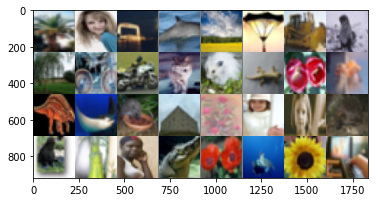

In [ ]:
import torchvision
# Show some images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# # print labels
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
from alexnet import AlexNet

alexnet = AlexNet(100).to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters())

In [ ]:
for epoch in range(3):
    running_loss = 0.0
    print(len(train_loader))
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.000
print("finished")
PATH = './alexnet.pth'
torch.save(alexnet.state_dict(), PATH)
        

1563
[1,   100] loss: 7.097
[1,   200] loss: 4.589
[1,   300] loss: 4.557
[1,   400] loss: 4.462
[1,   500] loss: 4.390
[1,   600] loss: 4.291
[1,   700] loss: 4.225
[1,   800] loss: 4.193
[1,   900] loss: 4.186
[1,  1000] loss: 4.181
[1,  1100] loss: 4.133
[1,  1200] loss: 4.110
[1,  1300] loss: 4.141
[1,  1400] loss: 4.059
[1,  1500] loss: 4.086
1563
[2,   100] loss: 3.985
[2,   200] loss: 3.959
[2,   300] loss: 3.950
[2,   400] loss: 3.945
[2,   500] loss: 3.956
[2,   600] loss: 3.946
[2,   700] loss: 3.921
[2,   800] loss: 3.864
[2,   900] loss: 3.846
[2,  1000] loss: 3.867
[2,  1100] loss: 3.835
[2,  1200] loss: 3.805
[2,  1300] loss: 3.799
[2,  1400] loss: 3.825
[2,  1500] loss: 3.776
1563
[3,   100] loss: 3.735
[3,   200] loss: 3.719
[3,   300] loss: 3.729
[3,   400] loss: 3.711
[3,   500] loss: 3.721
[3,   600] loss: 3.697
[3,   700] loss: 3.692
[3,   800] loss: 3.644
[3,   900] loss: 3.660
[3,  1000] loss: 3.681
[3,  1100] loss: 3.610
[3,  1200] loss: 3.627
[3,  1300] loss: 3.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        batch_size, n_crops, c, h, w = images.size()
        images = images.view(-1, c, h, w).to(device)
        labels = labels.to(device)
#         images = images.to(device)
#         labels = labels.to(device)

        outputs = alexnet(images)
        outputs = outputs.view(batch_size, n_crops, -1).mean(1)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))